## Example of Trans-C sampling across independent model states: Regression

This notebook demonstrates Bayesian sampling of a linear polynomial regression problem
using the Ensemble resampler.

In [5]:
# general python utility packages
import time
from collections import Counter
from functools import partial

import corner
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from scipy.optimize import minimize
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor


In [6]:
from pytransc.analysis.samples import resample_ensembles
from pytransc.analysis.visits import (
    count_state_changes,
    count_total_state_changes,
    get_acceptance_rate_between_states,
    get_autocorr_between_state_jumps,
    get_relative_marginal_likelihoods,
    get_visits_to_states,
)
from pytransc.samplers import run_ensemble_resampler, run_mcmc_per_state
from pytransc.utils.auto_pseudo import build_auto_pseudo_prior

In [7]:
def solveLS(d, G, Cdinv, mu=None, Cmpriorinv=None):  # Least squares solver
    """Solve the least squares problem given data, design matrix, and covariance matrices."""
    A = np.dot(np.transpose(G), Cdinv)  # Find solution
    GtG = np.dot(A, G)  # G^T C_inv G^T
    if (Cmpriorinv is not None) and (mu is not None):
        GtG += Cmpriorinv
    GtGinv = np.linalg.inv(GtG)  # Inverse of G^TC_inv G
    B = np.dot(A, d)
    if (Cmpriorinv is not None) and (mu is not None):
        B += np.dot(Cmpriorinv, mu)
    mls = np.dot(GtGinv, B)
    return mls, GtGinv

In [8]:
def calcE(dp, dobs, Cdinv, Cmpost, m, muprior, Cmpriorinv):
    """Calculate the evidence for the model given data, prior, and posterior covariances."""
    misfit = 0.5 * (np.dot((dobs - dp), np.dot(Cdinv, (dobs - dp))))
    misfit += 0.5 * (np.dot((muprior - m), np.dot(Cmpriorinv, (muprior - m))))
    f = np.sqrt(2 * np.pi) ** len(dp)
    detCdinv = np.linalg.det(Cdinv)
    detCmpost = np.linalg.det(Cmpost)
    detCmpriorinv = np.linalg.det(Cmpriorinv)
    E = np.sqrt(detCmpost * detCdinv * detCmpriorinv) * np.exp(-misfit) / f
    return E

--------

## Polynomial regression theory

Here we set up a problem of polynomial regression fitting a set of x,y data with up to a 4th order polynomial.

To begin with, we will work with polynomial curves, $$y(x) = \sum_{n=0}^N m_n x^n\,.$$
Here, $N$ is the 'order' of the polynomial: if $N=1$ we have a straight line, if $N=2$ it will be a quadratic, and so on. The $m_n$ are the 'model coefficients'.

To compute $y(x)$ for multiple $x$-values simultaneously, we  write $$ \left(\begin{array}{c}y_1\\y_2\\\vdots\\y_N\end{array}\right) = \left(\begin{array}{ccc}1&x_1&x_1^2\\1&x_2&x_2^2\\\vdots&\vdots&\vdots\\1&x_N&x_N^2\end{array}\right)\left(\begin{array}{c}m_0\\m_1\\m_2\end{array}\right)$$This has the general form, $\mathbf{d=Gm}$, and so the best-fitting model can be identified using a least-squares algorithm.

The maximum Likelihood solution for this problem is the model which minimizes

$$
\phi(\mathbf{m}) = \frac{1}{2} (\mathbf{d-Gm})^TC_D^{-1} (\mathbf{d-Gm}),
$$
which leads to

$$
{\bf m}_{LS} = \left(\mathbf{G}^T C_D^{-1} \mathbf{G}\right)^{-1}\mathbf{G}^T  C_D^{-1} \mathbf{d}.
$$

The *MAP* model, $\hat{{\bf m}}$, for this problem minimizes of the sum of the negative log-Likelihood and log-Gaussian prior 

$$
\phi(\mathbf{m}) = \frac{1}{2} (\mathbf{d-Gm})^TC_D^{-1} (\mathbf{d-Gm}) + \frac{1}{2} (\mathbf{m - m_o})^TC_M^{-1} (\mathbf{m - m_o})
$$

which leads to

$$
\hat{{\bf m}} = \left(\mathbf{G}^T C_D^{-1} \mathbf{G} + C_M^{-1}\right)^{-1}(\mathbf{G}^T  C_D^{-1} \mathbf{d} + C_M^{-1}\mathbf{m_o}).
$$

For Gaussian Likelihood and prior the evidence is a known analytical expression.

$$
p{(\bf d}) = \frac{e^{-\phi(\hat{{\bf m}})}}{(2\pi)^{N/2}} \left[ \frac{|\hat{C}_M|}{|C_D||C_M|}\right]^{1/2}.
$$
where $\hat{C}_M$ is the posterior model covariance, 

$$
\hat{C}_M = \left(\mathbf{G}^T C_D^{-1} \mathbf{G} + C_M^{-1}\right)^{-1}
$$

In [9]:
def getG(x, order):
    """Build design matrix, G for polynomial data fitting, at data points x up to order order."""
    return np.transpose([x ** (i) for i in range(order + 1)])

We generate some random samples from $y=3x/5+0.3$, add Gaussian random noise to them.

In [10]:
np.random.seed(61254557)  # noqa: NPY002
ndata, sigma = 20, 0.2
xobs = np.sort(np.random.rand(ndata))  # noqa: NPY002 ; x values of data
mtrue = np.array([0.3, 0.6])
G = getG(xobs, 1)
dobs = np.dot(G, mtrue) + np.random.normal(0, sigma, size=len(xobs))  # noqa: NPY002
Cdinv = np.eye(ndata) / (sigma**2)

Set up prior for Evidence calculation.

In [11]:
mls, Cmpost, G, Ev, maxorder = [], [], [], [], 3
Cmprior = [20 * np.eye(i + 1) for i in np.arange(maxorder + 1)]
Cmpriorinv = [0.05 * np.eye(i + 1) for i in np.arange(maxorder + 1)]
muprior = [np.zeros(i + 1) for i in np.arange(maxorder + 1)]

Solve least squares solution and calculate evidence for each model.

In [12]:
for i in range(maxorder + 1):
    Gp = getG(xobs, i)
    solp, Cmp = solveLS(dobs, Gp, Cdinv)  # Maximum Likelihood solution
    dpred = np.dot(Gp, solp)
    mls.append(solp)
    Cmpost.append(Cmp)
    G.append(Gp)
    solp2, Cmp2 = solveLS(
        dobs, Gp, Cdinv, mu=muprior[i], Cmpriorinv=Cmpriorinv[i]
    )  # MAP model and model covariance with Gaussian prior
    Ev.append(
        calcE(dpred, dobs, Cdinv, Cmp2, solp2, muprior[i], Cmpriorinv[i])
    )  # Analytical evidence calculation
Ev /= np.sum(Ev)

Plot solutions.

In [13]:
xplot = np.linspace(-0.25, 1.25, 100)
Gplot = getG(xplot, 1)
dplot = np.dot(Gplot, mtrue)
#
plt.figure(figsize=(8, 6))
plt.errorbar(xobs, dobs, yerr=sigma, capsize=3, fmt="ko", ecolor="grey", lw=0.5)
plt.plot(xplot, dplot, label="True", color="k", lw=0.8)
for i in range(maxorder + 1):
    Gplotp = getG(xplot, i)
    dpred = np.dot(Gplotp, mls[i])
    plt.plot(xplot, dpred, label="Best fit p=" + str(i), lw=0.5)
plt.xlabel("x")
plt.ylabel("y")
plt.ylim(-0.2, 1.3)
plt.legend()
plt.show()

In [14]:
# plot evidence values

fig, ax = plt.subplots()

fruits = [
    r"$y=m_o$",
    r"$y=m_o + m_1x$",
    r"$y = \sum_{i=0}^2 m_ix^i$",
    r"$y = \sum_{i=0}^3 m_ix^i$",
]
counts = [Ev[i] for i in range(maxorder + 1)]
bar_labels = [
    "Order 0",
    "Order 1",
    "Order 2",
    "Order 3",
]  # Define a list of labels, one for each bar

bar_colors = [
    "skyblue",
    "lightcoral",
    "lightgreen",
    "gold",
]  # Define a list of colors, one for each bar

ax.bar(fruits, counts, label=bar_labels, width=0.5, color=bar_colors)

ax.set_ylabel("Relative posterior evidence")
ax.set_title("Evidence estimate for each model")
ax.legend(title="Relative Evidence")

plt.show()

In [15]:
Ev

array([0.17163235, 0.64217786, 0.12414475, 0.06204504])

----------------

Set some global control parameters.

In [16]:
plotting = True  # Create some diagnostic displays of outputs
parallel = False  # Use parallel computation for sampling

### Log-posterior Likeihood, prior and PDF for each state

In [17]:
def _log_likelihood(x, state, dobs, G, Cdinv):
    """Calculate the log likelihood of the data given the model parameters."""
    dpred = np.dot(G[state], x)
    misfit = 0.5 * (np.dot((dobs - dpred), np.dot(Cdinv, (dobs - dpred))))
    f = np.sqrt(2 * np.pi) ** len(dpred)
    detCdinv = np.linalg.det(Cdinv)
    logL = -np.log(f) - misfit + np.log(detCdinv)
    return logL


log_likelihood = partial(_log_likelihood, dobs=dobs, G=G, Cdinv=Cdinv)

In [18]:
def _log_prior(x, state, muprior, Cmprior):
    """Calculate the log prior probability of the model parameters."""
    mu = muprior[state]
    cov = Cmprior[state]
    rv = stats.multivariate_normal(
        mean=mu, cov=cov
    )  # instance of multi-dimensional Gaussian
    return rv.logpdf(x)


log_prior = partial(_log_prior, muprior=muprior, Cmprior=Cmprior)

In [19]:
def log_posterior(x, state):
    """Multi-state log Posterior PDF evaluation (unormalised)."""
    return log_likelihood(x, state) + log_prior(x, state)

In [20]:
# first we optimize each state to find good starting point for all McMC samplers
rng = np.random.default_rng(42)
nstates = maxorder + 1  # Number of distinct states
ndims = [1, 2, 3, 4]  # Number of model parameters in each stateif(True):
nll = lambda *args: -log_posterior(*args)
ml = []
print("Maximum likelihood estimates:")
for i in range(nstates):
    initial = 0.5 * np.ones(i + 1)
    soln = minimize(nll, initial, args=(i,))
    ml.append(soln.x)
    print("x_ml ", soln.x)

Maximum likelihood estimates:
x_ml  [0.58148024]
x_ml  [0.37788932 0.48664353]
x_ml  [ 0.31354803  0.95796055 -0.52400543]
x_ml  [ 0.28548397  1.43950717 -1.83288492  0.8963229 ]


## Trans-C samping across model states with the Ensemble resampler 

Here we demonstrate use of the *Ensemble resampler*.

This formulation is equivalent to the *State-jump sampler* with the pseudo-prior being an approximation of the posterior PDF in each state. 

This consists of the following steps:
- Generate posterior ensembles in each state
- Build a pseudo prior PDF from these ensembles, and evaluate its log for all models in the ensembles.
- Sampler across the ensembles over the integer state label variable, $k$.

Run Ensemble resampler in each state separately.

### Preliminaries 

First find good starting models in each state, and then run Ensemble resampler in each state separately.

In [21]:
# setup of MCMC sampler
nsamples_es = 4 * [50000]  # number of samples per chain for sampling of each state
nwalkers_es = 4 * [32]  # number of mcmc chains to run in each state
pos = []
for i in range(nstates):  # generate starting points for each chain in each state
    pos.append(
        ml[i] + 1e-4 * rng.standard_normal((nwalkers_es[i], ndims[i]))
    )  # add random perturbation to maximum Likelihood models

In [22]:
# run Ensemble sampler in each state
start_time = time.time()
ensemble_per_state, log_posterior_ens = run_mcmc_per_state(
    nstates,  # number of states
    ndims,  # number of dimensions in each state
    nwalkers_es,  # int or list containing number of walkers for each state
    nsamples_es,  # number of chain steps per walker
    pos,  # starting positions for walkers in each state
    log_posterior,  # log Likelihood x log_prior
    discard=0,  # burnin number of chain steps to discard in eeach state
    auto_thin=True,  # thinning value, save every `thin` models
)  # show progress bar for each state
elapsed_time = time.time() - start_time

print(
    " Elapsed time                                     :",
    np.round(elapsed_time, 2),
    "s \n",
)
print(
    " Number of samples in each state                  :",
    *[len(ensemble_per_state[i]) for i in range(nstates)],
)


Running within-state sampler separately on each state

Number of walkers               :  [32, 32, 32, 32]

Number of states being sampled:  4
Dimensions of each state:  [1, 2, 3, 4]


  6%|███▉                                                                    | 2773/50000 [00:23<06:31, 120.57it/s]Traceback (most recent call last):
  File "/home/jrh/.virtualenvs/inlab/lib/python3.13/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)
           ~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_56479/3816221811.py", line 3, in log_posterior
    return log_likelihood(x, state) + log_prior(x, state)
                                      ~~~~~~~~~^^^^^^^^^^
  File "/tmp/ipykernel_56479/3642051595.py", line 5, in _log_prior
    rv = stats.multivariate_normal(
        mean=mu, cov=cov
    )  # instance of multi-dimensional Gaussian
  File "/home/jrh/.virtualenvs/inlab/lib64/python3.13/site-packages/scipy/stats/_multivariate.py", line 401, in __call__
    return multivariate_normal_frozen(mean, cov,
                                      allow_singular=allow_singular,
                                      seed=se

emcee: Exception while calling your likelihood function:
  params: [0.28347646 0.59542034]
  args: []
  kwargs: {}
  exception:


KeyboardInterrupt: 

Performing auto thinning of ensemble...
 Elapsed time                                     : 342.1 s 

 Number of samples in each state                  : 114282 94114 79996 63996


In [26]:
n_state_procs=4
with ProcessPoolExecutor(max_workers=n_state_procs) as state_pool:
        ensemble_per_state_A, log_posterior_ens_A = run_mcmc_per_state(
            nstates,
            ndims,
            nwalkers_es,
            nsamples_es,
            pos,
            log_posterior,
            discard=0,
            state_pool=state_pool,
            auto_thin=True
        )


Running within-state sampler separately on each state

Number of walkers               :  [32, 32, 32, 32]

Number of states being sampled:  4
Dimensions of each state:  [1, 2, 3, 4]
Using state-level parallelism


  3%|██▍                                                                      | 1634/50000 [00:16<08:09, 98.91it/s]

emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:



  params:  params:  params:  params:    [0.6454625][ 0.20720754  1.50271887 -0.87759807][ 0.37861809  1.51157506 -2.78044894  2.07426278]

[0.27791953 0.63435726]
  args:  args:  args:
     args:[][][] 


[]  kwargs:  kwargs:  kwargs:
     kwargs:{}{}{} 


{}  exception:  exception:  exception:


  exception:


Traceback (most recent call last):
Traceback (most recent call last):


Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/jrh/.virtualenvs/inlab/lib/python3.13/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)
           ~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jrh/.virtualenvs/inlab/lib/python3.13/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)
           ~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_56479/3816221811.py", line 3, in log_posterior
    return log_likelihood(x, state) + log_prior(x, state)
                                      ~~~~~~~~~^^^^^^^^^^
  File "/tmp/ipykernel_56479/3816221811.py", line 3, in log_posterior
    return log_likelihood(x, state) + log_prior(x, state)
                                      ~~~~~~~~~^^^^^^^^^^
  File "/home/jrh/.virtualenvs/inlab/lib/python3.13/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kw

KeyboardInterrupt: 

In [ ]:
n_state_procs=4
n_walker_procs=8
with ProcessPoolExecutor(max_workers=n_state_procs) as state_pool, \
     ProcessPoolExecutor(max_workers=n_walker_procs) as walker_pool:
    
    ensemble_per_state_B, log_posterior_ens_B = run_mcmc_per_state(
        nstates,
        ndims,
        nwalkers_es,
        nsamples_es,
        pos,
        log_posterior=log_posterior,
        state_pool=state_pool,
        emcee_pool=walker_pool,
    )


Running within-state sampler separately on each state

Number of walkers               :  [32, 32, 32, 32]

Number of states being sampled:  4
Dimensions of each state:  [1, 2, 3, 4]
Using state-level parallelism
Using emcee-level parallelism


  1%|▋                                                                         | 446/50000 [00:07<14:44, 56.03it/s]Process ForkProcess-12:3:
Process ForkProcess-9:6:
Process ForkProcess-12:4:


emcee: Exception while calling your likelihood function:

Process ForkProcess-9:4:


emcee: Exception while calling your likelihood function:

Process ForkProcess-9:5:


emcee: Exception while calling your likelihood function:

Process ForkProcess-12:5:
Process ForkProcess-10:3:


emcee: Exception while calling your likelihood function:

Process ForkProcess-9:3:


emcee: Exception while calling your likelihood function:

Process ForkProcess-9:1:
Process ForkProcess-11:4:
Process ForkProcess-12:7:
Process ForkProcess-12:8:
Process ForkProcess-11:7:
Process ForkProcess-11:8:
Process ForkProcess-11:3:
Process ForkProcess-9:7:
Process ForkProcess-12:6:
Process ForkProcess-11:1:
Process ForkProcess-9:8:


emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:


Process ForkProcess-12:1:
Process ForkProcess-11:6:
Process ForkProcess-9:2:
Process ForkProcess-11:2:
Process ForkProcess-12:2:
Process ForkProcess-11:5:


Traceback (most recent call last):


Traceback (most recent call last):
Traceback (most recent call last):


Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):


Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):


Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):


  params:

Traceback (most recent call last):


  params:

Traceback (most recent call last):


  params:

Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):


  params:  params:

Traceback (most recent call last):
  File "/usr/lib64/python3.13/multiprocessing/process.py", line 313, in _bootstrap
    self.run()
    ~~~~~~~~^^
  File "/usr/lib64/python3.13/multiprocessing/process.py", line 313, in _bootstrap
    self.run()
    ~~~~~~~~^^
Traceback (most recent call last):
  File "/usr/lib64/python3.13/multiprocessing/process.py", line 313, in _bootstrap
    self.run()
    ~~~~~~~~^^


  params:

  File "/usr/lib64/python3.13/multiprocessing/process.py", line 313, in _bootstrap
    self.run()
    ~~~~~~~~^^


  params:

  File "/usr/lib64/python3.13/multiprocessing/process.py", line 313, in _bootstrap
    self.run()
    ~~~~~~~~^^
  File "/usr/lib64/python3.13/multiprocessing/process.py", line 313, in _bootstrap
    self.run()
    ~~~~~~~~^^
  File "/usr/lib64/python3.13/multiprocessing/process.py", line 313, in _bootstrap
    self.run()
    ~~~~~~~~^^
  File "/usr/lib64/python3.13/multiprocessing/process.py", line 313, in _bootstrap
    self.run()
    ~~~~~~~~^^


  File "/usr/lib64/python3.13/multiprocessing/process.py", line 313, in _bootstrap
    self.run()
    ~~~~~~~~^^
  File "/usr/lib64/python3.13/multiprocessing/process.py", line 313, in _bootstrap
    self.run()
    ~~~~~~~~^^
  File "/usr/lib64/python3.13/multiprocessing/process.py", line 313, in _bootstrap
    self.run()
    ~~~~~~~~^^
  File "/usr/lib64/python3.13/multiprocessing/process.py", line 313, in _bootstrap
    self.run()
    ~~~~~~~~^^
  File "/usr/lib64/python3.13/multiprocessing/process.py", line 313, in _bootstrap
    self.run()
    ~~~~~~~~^^


  File "/usr/lib64/python3.13/multiprocessing/process.py", line 313, in _bootstrap
    self.run()
    ~~~~~~~~^^


  File "/usr/lib64/python3.13/multiprocessing/process.py", line 313, in _bootstrap
    self.run()
    ~~~~~~~~^^
  File "/usr/lib64/python3.13/multiprocessing/process.py", line 313, in _bootstrap
    self.run()
    ~~~~~~~~^^
  File "/usr/lib64/python3.13/multiprocessing/process.py", line 313, in _bootstrap
    self.run()
    ~~~~~~~~^^
  File "/usr/lib64/python3.13/multiprocessing/process.py", line 313, in _bootstrap
    self.run()
    ~~~~~~~~^^


  File "/usr/lib64/python3.13/multiprocessing/process.py", line 313, in _bootstrap
    self.run()
    ~~~~~~~~^^


  File "/usr/lib64/python3.13/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib64/python3.13/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib64/python3.13/multiprocessing/process.py", line 313, in _bootstrap
    self.run()
    ~~~~~~~~^^
  File "/usr/lib64/python3.13/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib64/python3.13/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


  File "/usr/lib64/python3.13/multiprocessing/process.py", line 313, in _bootstrap
    self.run()
    ~~~~~~~~^^


  File "/usr/lib64/python3.13/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib64/python3.13/multiprocessing/process.py", line 313, in _bootstrap
    self.run()
    ~~~~~~~~^^
  File "/usr/lib64/python3.13/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib64/python3.13/multiprocessing/process.py", line 313, in _bootstrap
    self.run()
    ~~~~~~~~^^
  File "/usr/lib64/python3.13/multiprocessing/process.py", line 313, in _bootstrap
    self.run()
    ~~~~~~~~^^
  File "/usr/lib64/python3.13/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib64/python3.13/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^

[0.39588655 0.46224079]

  File "/usr/lib64/python3.13/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib64/python3.13/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib64/python3.13/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


[0.34352805 0.60487847]

  File "/usr/lib64/python3.13/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


[0.31850991 0.57969603]

  File "/usr/lib64/python3.13/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


[-0.03187003  1.05953383]

  File "/usr/lib64/python3.13/concurrent/futures/process.py", line 242, in _process_worker
    call_item = call_queue.get(block=True)
  File "/usr/lib64/python3.13/concurrent/futures/process.py", line 242, in _process_worker
    call_item = call_queue.get(block=True)
  File "/usr/lib64/python3.13/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


[0.22391735 0.81009772]

  File "/usr/lib64/python3.13/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib64/python3.13/concurrent/futures/process.py", line 242, in _process_worker
    call_item = call_queue.get(block=True)
  File "/usr/lib64/python3.13/concurrent/futures/process.py", line 242, in _process_worker
    call_item = call_queue.get(block=True)
  File "/usr/lib64/python3.13/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


[0.37229583 0.46098837]

  File "/usr/lib64/python3.13/concurrent/futures/process.py", line 242, in _process_worker
    call_item = call_queue.get(block=True)


[0.26371305 0.60991904]

  File "/usr/lib64/python3.13/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib64/python3.13/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib64/python3.13/concurrent/futures/process.py", line 242, in _process_worker
    call_item = call_queue.get(block=True)
  File "/usr/lib64/python3.13/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib64/python3.13/concurrent/futures/process.py", line 242, in _process_worker
    call_item = call_queue.get(block=True)
  File "/usr/lib64/python3.13/concurrent/futures/process.py", line 242, in _process_worker
    call_item = call_queue.get(block=True)
  File "/usr/lib64/python3.13/concurrent/futures/process.py", line 242, in _process_worker
   

  File "/usr/lib64/python3.13/concurrent/futures/process.py", line 242, in _process_worker
    call_item = call_queue.get(block=True)
  File "/usr/lib64/python3.13/concurrent/futures/process.py", line 242, in _process_worker
    call_item = call_queue.get(block=True)
  File "/usr/lib64/python3.13/concurrent/futures/process.py", line 242, in _process_worker
    call_item = call_queue.get(block=True)


  File "/usr/lib64/python3.13/concurrent/futures/process.py", line 242, in _process_worker
    call_item = call_queue.get(block=True)


  File "/usr/lib64/python3.13/concurrent/futures/process.py", line 242, in _process_worker
    call_item = call_queue.get(block=True)


  File "/usr/lib64/python3.13/multiprocessing/queues.py", line 100, in get
    with self._rlock:
         ^^^^^^^^^^^
  File "/usr/lib64/python3.13/multiprocessing/queues.py", line 100, in get
    with self._rlock:
         ^^^^^^^^^^^
  File "/usr/lib64/python3.13/concurrent/futures/process.py", line 242, in _process_worker
    call_item = call_queue.get(block=True)
  File "/usr/lib64/python3.13/multiprocessing/queues.py", line 100, in get
    with self._rlock:
         ^^^^^^^^^^^
  File "/usr/lib64/python3.13/concurrent/futures/process.py", line 242, in _process_worker
    call_item = call_queue.get(block=True)


  File "/usr/lib64/python3.13/multiprocessing/queues.py", line 100, in get
    with self._rlock:
         ^^^^^^^^^^^
  File "/usr/lib64/python3.13/concurrent/futures/process.py", line 242, in _process_worker
    call_item = call_queue.get(block=True)


  File "/usr/lib64/python3.13/multiprocessing/queues.py", line 100, in get
    with self._rlock:
         ^^^^^^^^^^^
  File "/usr/lib64/python3.13/concurrent/futures/process.py", line 242, in _process_worker
    call_item = call_queue.get(block=True)


  File "/usr/lib64/python3.13/multiprocessing/queues.py", line 100, in get
    with self._rlock:
         ^^^^^^^^^^^
  File "/usr/lib64/python3.13/multiprocessing/queues.py", line 100, in get
    with self._rlock:
         ^^^^^^^^^^^
  File "/usr/lib64/python3.13/concurrent/futures/process.py", line 242, in _process_worker
    call_item = call_queue.get(block=True)
  File "/usr/lib64/python3.13/concurrent/futures/process.py", line 242, in _process_worker
    call_item = call_queue.get(block=True)
  File "/usr/lib64/python3.13/multiprocessing/queues.py", line 100, in get
    with self._rlock:
         ^^^^^^^^^^^
  File "/usr/lib64/python3.13/multiprocessing/queues.py", line 100, in get
    with self._rlock:
         ^^^^^^^^^^^
  File "/usr/lib64/python3.13/multiprocessing/queues.py", line 100, in get
    with self._rlock:
         ^^^^^^^^^^^
  File "/usr/lib64/python3.13/multiprocessing/queues.py", line 101, in get
    res = self._recv_bytes()
  File "/usr/lib64/python3.13/multipro

  args:

  File "/usr/lib64/python3.13/multiprocessing/queues.py", line 101, in get
    res = self._recv_bytes()
  File "/usr/lib64/python3.13/concurrent/futures/process.py", line 242, in _process_worker
    call_item = call_queue.get(block=True)
  File "/usr/lib64/python3.13/multiprocessing/queues.py", line 101, in get
    res = self._recv_bytes()
  File "/usr/lib64/python3.13/multiprocessing/queues.py", line 101, in get
    res = self._recv_bytes()


  args:

  File "/usr/lib64/python3.13/multiprocessing/queues.py", line 100, in get
    with self._rlock:
         ^^^^^^^^^^^


  args:

  File "/usr/lib64/python3.13/multiprocessing/queues.py", line 100, in get
    with self._rlock:
         ^^^^^^^^^^^
  File "/usr/lib64/python3.13/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
           ~~~~~~~~~~~~~~~~~~~~~~~^^


  args:

  File "/usr/lib64/python3.13/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
           ~~~~~~~~~~~~~~~~~~~~~~~^^
  File "/usr/lib64/python3.13/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
           ~~~~~~~~~~~~~~~~~~~~~~~^^


  args:

  File "/usr/lib64/python3.13/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
           ~~~~~~~~~~~~~~~~~~~~~~~^^
  File "/usr/lib64/python3.13/multiprocessing/queues.py", line 100, in get
    with self._rlock:
         ^^^^^^^^^^^
  File "/usr/lib64/python3.13/multiprocessing/queues.py", line 100, in get
    with self._rlock:
         ^^^^^^^^^^^
  File "/usr/lib64/python3.13/multiprocessing/queues.py", line 100, in get
    with self._rlock:
         ^^^^^^^^^^^


  args:

  File "/usr/lib64/python3.13/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
           ~~~~~~~~~~~~~~~~~~~~~~~^^
  File "/usr/lib64/python3.13/multiprocessing/queues.py", line 100, in get
    with self._rlock:
         ^^^^^^^^^^^


  args:

  File "/usr/lib64/python3.13/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
           ~~~~~~~~~~~~~~~~~~~~~~~^^
  File "/usr/lib64/python3.13/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
           ~~~~~~~~~~~~~~~~~~~~~~~^^
  File "/usr/lib64/python3.13/multiprocessing/queues.py", line 100, in get
    with self._rlock:
         ^^^^^^^^^^^
  File "/usr/lib64/python3.13/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
           ~~~~~~~~~~~~~~~~~~~~~~~^^
  File "/usr/lib64/python3.13/multiprocessing/queues.py", line 100, in get
    with self._rlock:
         ^^^^^^^^^^^
  File "/usr/lib64/python3.13/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
           ~~~~~~~~~~~~~~~~~~~~~~~^^
  File "/usr/lib64/python3.13/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
      

  File "/usr/lib64/python3.13/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
           ~~~~~~~~~~~~~~~~~~~~~~~^^
  File "/usr/lib64/python3.13/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/usr/lib64/python3.13/multiprocessing/queues.py", line 100, in get
    with self._rlock:
         ^^^^^^^^^^^
  File "/usr/lib64/python3.13/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)


  File "/usr/lib64/python3.13/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
           ~~~~~~~~~~~~~~~~~~~~~~~^^


  File "/usr/lib64/python3.13/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/usr/lib64/python3.13/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
           ~~~~~~~~~~~~~~~~~~~~~~~^^


KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt


KeyboardInterrupt
  File "/usr/lib64/python3.13/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
           ~~~~~~~~~~~~~~~~~~~~~~~^^
  File "/usr/lib64/python3.13/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
           ~~~~~~~~~~~~~~~~~~~~~~~^^


  File "/usr/lib64/python3.13/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
           ~~~~~~~~~~~~~~~~~~~~~~~^^
KeyboardInterrupt
  File "/usr/lib64/python3.13/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
           ~~~~~~~~~~~~~~~~~~~~~~~^^


KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File "/usr/lib64/python3.13/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
           ~~~~~~~~~~~~~~~~~~~~~~~^^
  File "/usr/lib64/python3.13/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
           ~~~~~~~~~~~~~~~~~~~~~~~^^
KeyboardInterrupt
  File "/usr/lib64/python3.13/multiprocessing/connection.py", line 430, in _recv_bytes
    buf = self._recv(4)
KeyboardInterrupt
KeyboardInterrupt


[]

KeyboardInterrupt
  File "/usr/lib64/python3.13/multiprocessing/connection.py", line 430, in _recv_bytes
    buf = self._recv(4)
  File "/usr/lib64/python3.13/multiprocessing/connection.py", line 430, in _recv_bytes
    buf = self._recv(4)
  File "/usr/lib64/python3.13/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
           ~~~~~~~~~~~~~~~~~~~~~~~^^


[]

KeyboardInterrupt


[]

  File "/usr/lib64/python3.13/multiprocessing/connection.py", line 430, in _recv_bytes
    buf = self._recv(4)
KeyboardInterrupt


[][]

KeyboardInterrupt
KeyboardInterrupt


[]

KeyboardInterrupt
KeyboardInterrupt


[]

KeyboardInterrupt


  File "/usr/lib64/python3.13/multiprocessing/connection.py", line 395, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt
  File "/usr/lib64/python3.13/multiprocessing/connection.py", line 395, in _recv
    chunk = read(handle, remaining)
  File "/usr/lib64/python3.13/multiprocessing/connection.py", line 395, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


  File "/usr/lib64/python3.13/multiprocessing/connection.py", line 395, in _recv
    chunk = read(handle, remaining)


KeyboardInterrupt


  kwargs:

KeyboardInterrupt
KeyboardInterrupt


  kwargs:  kwargs:  kwargs:

KeyboardInterrupt


 
 {}   kwargs:  kwargs:{}   {}  kwargs:{}
{}{}

 
  exception:
  exception:
  exception:  exception:{}

  exception:  exception:






Traceback (most recent call last):


  exception:

Traceback (most recent call last):


Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/jrh/.virtualenvs/inlab/lib/python3.13/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)
           ~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Traceback (most recent call last):
  File "/tmp/ipykernel_56479/3816221811.py", line 3, in log_posterior
    return log_likelihood(x, state) + log_prior(x, state)
                                      ~~~~~~~~~^^^^^^^^^^
  File "/home/jrh/.virtualenvs/inlab/lib/python3.13/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)
           ~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_56479/3642051595.py", line 5, in _log_prior
    rv = stats.multivariate_normal(
        mean=mu, cov=cov
    )  # instance of multi-dimensional Gaussian
  File "/home/jrh/.virtualenvs/inlab/lib/python3.13/site-packages/emcee/ensemble.py", line

In [20]:
# corner plots to check sampling within each state (if desired)
if False:
    contour_kwargs = {"linewidths": 0.5}
    data_kwargs = {"color": "darkblue"}
    data_kwargs = {"color": "slateblue"}
    for i in range(1, nstates):
        string = "Order " + str(i)
        print(" State; ", i, " in ", ndims[i], " dimensions")
        fig = corner.corner(
            ensemble_per_state[i],
            truths=ml[i],
            title=string,
            bins=40,
            hist_bin_factor=2,
            smooth=True,
            contour_kwargs=contour_kwargs,
            data_kwargs=data_kwargs,
        )

#### Build pseudo priors by fitting a Gaussian mixture to posterior ensembles in each state

Fit a mixture model in each state to create an automatic pseudo prior, and then evaluate that pseudo_prior for all points in the ensembles. This uses the posterior ensembles `ensemble_per_state[s],s=1,...,nstates` and produces an ensemble of log-pseudo-prior values which are placed in `log_pseudo_prior_ens[s],s=1,...,nstates`. These are then provided to the ensemble resampler `run_ensemble_resampler`.

In [21]:
log_pseudo_prior = build_auto_pseudo_prior(ensemble_per_state=ensemble_per_state)
log_pseudo_prior_ens = []
for i, ens in enumerate(ensemble_per_state):
    log_pseudo_prior_ens.append(np.array([log_pseudo_prior(x, i) for x in ens]))

In [22]:
# Calculate marginal Likelihoods using ensembles for each state
nwalkers_er = 32  # number of independent random walkers across ensembles
nsteps_er = 100000  # number of chain steps for each walker
start_time = time.time()
resampler_chains = run_ensemble_resampler(
    nwalkers_er,
    nsteps_er,
    nstates,
    ndims,
    log_posterior_ens=log_posterior_ens,
    log_pseudo_prior_ens=log_pseudo_prior_ens,
    parallel=parallel,
    progress=True,
)  # run mcmc sampler over ensembles to get marginal Likelihoods between states
elapsed_time = time.time() - start_time

alg = "TransC-ensemble-resampler"
state_chain_tot = np.swapaxes(resampler_chains.state_chain_tot, 0, 1)
state_chain = resampler_chains.state_chain.T
accept_within_per_walker = 1.0 * np.ones(nwalkers_er)
accept_between_per_walker = resampler_chains.n_accepted / nsteps_er
accept_within = 100 * np.mean(accept_within_per_walker)
accept_between = 100 * np.mean(accept_between_per_walker)
nsamples = [len(a) for a in log_posterior_ens]

2025-07-31 17:15:20 [INFO] pytransc.samplers.ensemble_resampler: 
Running ensemble resampler
2025-07-31 17:15:20 [INFO] pytransc.samplers.ensemble_resampler: 
Number of walkers               : 32
2025-07-31 17:15:20 [INFO] pytransc.samplers.ensemble_resampler: Number of states being sampled  : 4
2025-07-31 17:15:20 [INFO] pytransc.samplers.ensemble_resampler: Dimensions of each state        : [1, 2, 3, 4]
100%|██████████| 32/32 [00:08<00:00,  3.90it/s]


In [ ]:
# print some diagnostics
print("\n Algorithm type                                      :", alg)
print(
    " Average % acceptance rate for within states         :",
    np.round(accept_within, 2),
)
print(
    " Average % acceptance rate for between states        :",
    np.round(accept_between, 2),
)

# extract trans-D samples and chains
discard = 0  # chain burnin
thin = 15  # chain thinning
visits, states_chain = get_visits_to_states(
    transc_sampler=resampler_chains,
    discard=discard,
    thin=thin,
    normalize=True,
)
visits = visits.swapaxes(0, 1)  # (n_steps, n_walkers, n_states)
states_chain = states_chain.swapaxes(0, 1)  # (n_steps, n_walkers)

state_changes_per_walker = count_state_changes(
    resampler_chains.state_chain, discard=discard, thin=thin
)
total_state_changes = count_total_state_changes(
    resampler_chains.state_chain, discard=discard, thin=thin
)
acceptance_rate_between_states = get_acceptance_rate_between_states(
    resampler_chains, discard=discard, thin=thin
)
autocorr_time_for_between_state_jumps = get_autocorr_between_state_jumps(
    resampler_chains.state_chain
)
relative_marginal_likelihoods = get_relative_marginal_likelihoods(
    resampler_chains.state_chain_tot[:, -1, :]
)

print(
    " Auto correlation time for between state sampling    :",
    np.round(autocorr_time_for_between_state_jumps, 3),
)
print(" Total number of state changes for all walkers       :", total_state_changes)
print(
    " Number of state changes for each walker             :\n",
    *state_changes_per_walker,
)
print(" Analytic relative marginal Likelihoods              :", *np.round(Ev, 5))
print(
    " Estimated relative evidences                        :",
    *np.round((relative_marginal_likelihoods), 5),
)
print(
    " Elapsed time                                        :",
    np.round(elapsed_time, 2),
    "s \n",
)


 Algorithm type                                      : TransC-ensemble-resampler
 Average % acceptance rate for within states         : 100.0
 Average % acceptance rate for between states        : 39.11
 Auto correlation time for between state sampling    : 0.984
 Total number of state changes for all walkers       : 113717
 Number of state changes for each walker             :
 3560 3620 3546 3681 3632 3610 3500 3528 3611 3494 3604 3594 3624 3527 3638 3491 3541 3475 3529 3514 3554 3553 3549 3575 3461 3529 3554 3587 3545 3481 3502 3508
 Analytic relative marginal Likelihoods              : 0.17163 0.64218 0.12414 0.06205
 Estimated relative evidences                        : 0.17342 0.64732 0.12489 0.05437
 Elapsed time                                        : 8.2 s 



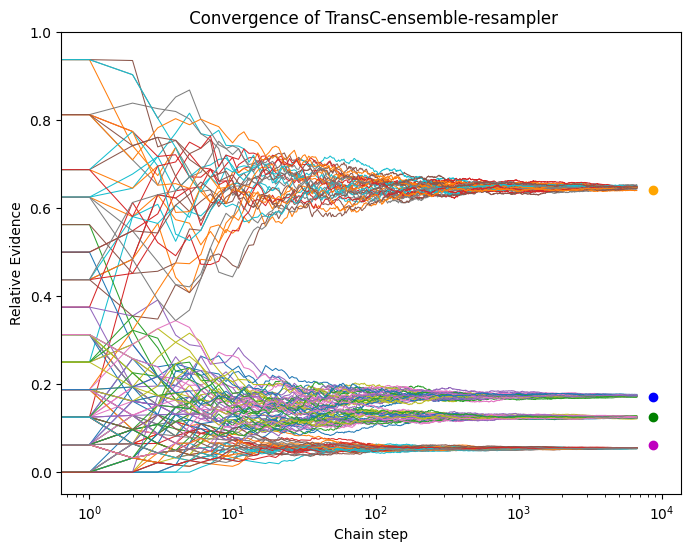

In [24]:
# plot relative number of visit to each state along the chain
if plotting:
    fig, axes = plt.subplots(figsize=(8, 6))
    if visits.ndim == 3:  # plot chains for each state and walker
        plt.semilogx(visits.reshape(np.shape(visits)[0], -1), lw=0.75)
    elif visits.ndim == 2:  # plot chains for each state average over walkers
        plt.semilogx(
            visits.reshape(np.shape(visits)[0], -1),
            lw=0.75,
            label=["State 1", "State 2", "State 3"],
        )
        plt.legend()
    plt.xlabel("Chain step")
    plt.ylabel("Relative Evidence")
    plt.plot(len(visits) * 1.3, Ev[0], "bo")
    plt.plot(len(visits) * 1.3, Ev[1], "o", color="orange")
    plt.plot(len(visits) * 1.3, Ev[2], "go")
    plt.plot(len(visits) * 1.3, Ev[3], "mo")
    plt.title(" Convergence of " + alg)
    plt.ylim(-0.05, 1.0)
    # plt.savefig('ER_chains.pdf')

    plt.show()

Coloured dots show the true relative normalization constants for each Gaussian. As you can see the chains are 
converging, and visiting each state in proportion to the correct normalization constant. 

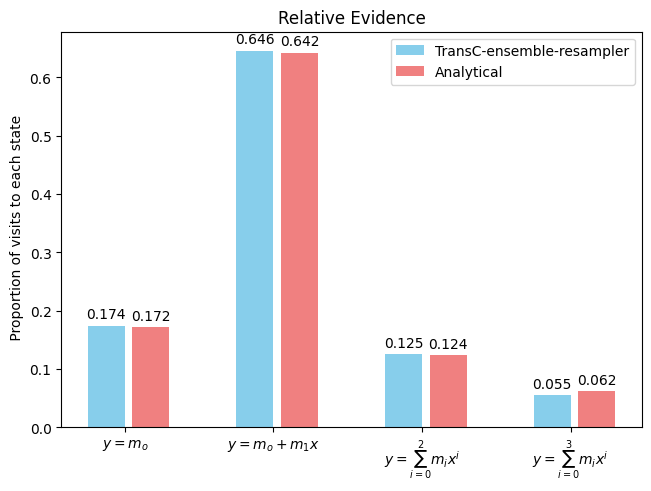

In [25]:
# Count visits to each state by Trans-D mcmc
if plotting:
    h = np.zeros(nstates)
    h[list(Counter(states_chain.reshape(-1)).keys())] = list(
        Counter(states_chain.reshape(-1)).values()
    )
    h /= np.sum(h)
    # plot histogram of frequency of visits to each state

    labels = [
        r"$y=m_o$",
        r"$y=m_o + m_1x$",
        r"$y = \sum_{i=0}^2 m_ix^i$",
        r"$y = \sum_{i=0}^3 m_ix^i$",
    ]
    x = np.arange(nstates)  # the label locations
    width = 0.25  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(layout="constrained")
    offset = width * multiplier
    rects = ax.bar(x + offset, np.round(h, 3), width, label=alg, color="skyblue")
    ax.bar_label(rects, padding=3)
    multiplier += 1
    offset = width * multiplier + 0.05
    rects = ax.bar(
        x + offset, np.round(counts, 3), width, label="Analytical", color="lightcoral"
    )
    ax.bar_label(rects, padding=3)
    multiplier += 1
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(" Proportion of visits to each state")
    ax.set_title("Relative Evidence")
    ax.set_xticks(x + width / 2, labels)
    ax.legend(loc="upper right")
    # plt.savefig('ER_relative_evidences.pdf')
    plt.show()

 State;  1  in  2  dimensions
 State;  2  in  3  dimensions
 State;  3  in  4  dimensions


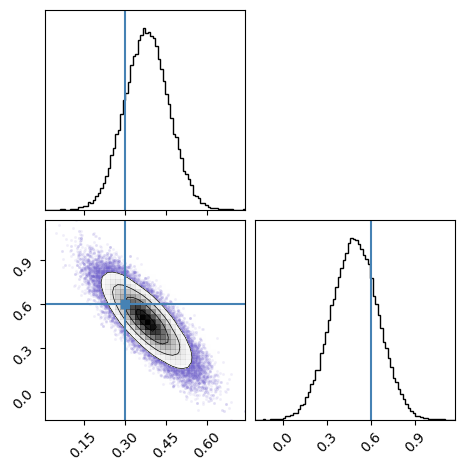

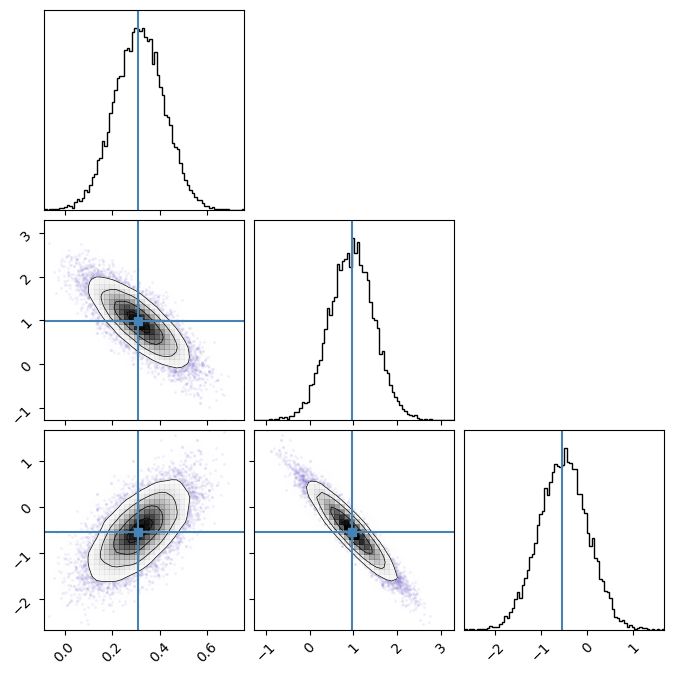

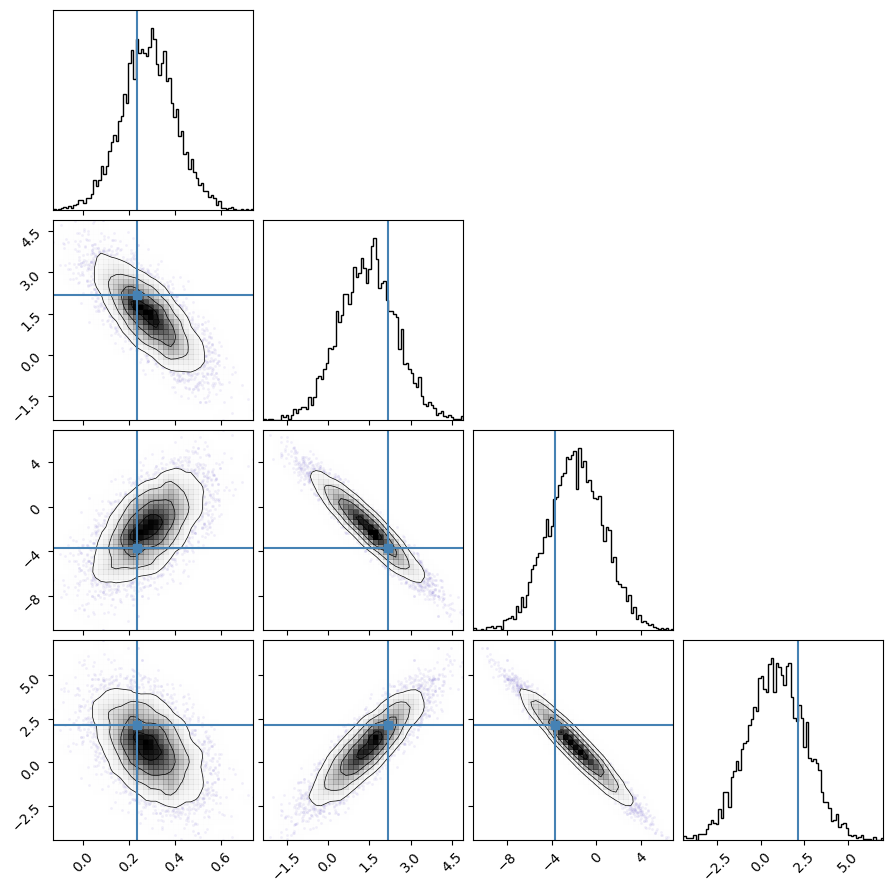

In [ ]:
# corner plots to check sampling within each state
if plotting:
    muplot = mls.copy()
    muplot[1] = mtrue
    # collect trans samples
    transc_ensemble = resample_ensembles(
        ensemble_per_state,
        relative_marginal_likelihoods,
        100_000,
    )
    contour_kwargs = {"linewidths": 0.5}
    data_kwargs = {"color": "slateblue"}
    for i in range(1, nstates):
        string = "Order " + str(i)
        print(" State; ", i, " in ", ndims[i], " dimensions")
        fig = corner.corner(
            transc_ensemble[i],
            truths=muplot[i],
            title=string,
            bins=40,
            hist_bin_factor=2,
            smooth=True,
            contour_kwargs=contour_kwargs,
            data_kwargs=data_kwargs,
        )
# fig.savefig('ER_corner_'+str(i)+'.pdf')

In [27]:
print(
    f" Here is the Trans-C ensemble with\n {len(transc_ensemble[0])} samples in state 1\n {len(transc_ensemble[1])} samples in state 2\n {len(transc_ensemble[2])} samples in state 3\n",
    "\n",
    transc_ensemble,
)

 Here is the Trans-C ensemble with
 17318 samples in state 1
 64791 samples in state 2
 12538 samples in state 3
 
 [array([[0.58634916],
       [0.64146026],
       [0.610328  ],
       ...,
       [0.60346463],
       [0.60910921],
       [0.64589607]], shape=(17318, 1)), array([[0.31757643, 0.67141062],
       [0.3032063 , 0.4625394 ],
       [0.4840059 , 0.36517341],
       ...,
       [0.38823183, 0.26051317],
       [0.42420402, 0.36906143],
       [0.42124234, 0.31547105]], shape=(64791, 2)), array([[ 0.22475285,  1.52082965, -0.88604482],
       [ 0.24940331,  1.55339552, -1.23546692],
       [ 0.23723277,  1.50636336, -0.93410242],
       ...,
       [ 0.4517759 ,  0.5341132 , -0.14753305],
       [ 0.21528564,  1.5272545 , -0.95981893],
       [ 0.40759294,  0.58562051, -0.26887154]], shape=(12538, 3)), array([[ 0.25769556,  1.41265268, -2.28295786,  1.58180126],
       [ 0.28283703,  1.29925717, -1.09499847,  0.07136946],
       [ 0.21351918,  2.59654996, -3.66770894,  1.656

---------